In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [17]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_old(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]

def get_polar_slice(theta,phi,val=0.0): # assume val in angle
    
    # get a slice through a particular angle - phi = radius, theta = angle
    # this means get all phi values, for theta = value and 180+value
    # the 180+values define as negative phi
    
    # this gradually increases the tolerance until it finds something
    # relevant tolerance is theta (get all theta values)
    tol = abs(theta[1,0] - theta[0,0])/1.5
    N = len(theta[:,0]) #figure out the importance of this 
    #ok = True
    #while(ok):
    sliceIndex1 = np.where(
            (theta[:,0] < (val + tol)) & 
            (theta[:,0] > (val - tol)))[0][0]
    sliceIndex2 = np.where(
            (theta[:,0] < (np.pi + val + tol)) & 
            (theta[:,0] > (np.pi + val - tol)))[0][0]
    return sliceIndex1, sliceIndex2


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

In [4]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

# after looking through the slices and being very picky
good_freqs =  [538, 553, 554,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
       702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803,
       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
       932, 933, 935, 936, 937, 938, 939]

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

# POLAR - Read in a single co-added beam pickle and plot maps, slices

In [12]:
# First get appropriate columns for angles = 0,45,90

# set which pol:
copoldir = 'N'
pols = N_pols

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

print(ptest.d0_edges_grid[2,0,chind]-ptest.d0_edges_grid[1,0,chind]) # d0 is theta, d1 is phi
N = len(ptest.d0_centers_grid[:,0,0])
print(N)

chind = pols[0]
col1_0,col2_0 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0)
col1_45,col2_45 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/4.0)
col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2.0)
print(col1_0, col2_0,col1_45, col2_45,col1_90, col2_90)

#print(ptest.d0_edges_grid[:,0,chind]) # get the 2nd index
print(ptest.d0_centers_grid[col1_0,:,chind])

print(ptest.d0_centers_grid[col2_0,:,chind])

print(ptest.d1_centers_grid[col1_0,:,chind])

0.10649466622338281
59
0.0 0.07099644414892188 0.07099644414892188 -0.07099644414892188
0 29
0.7853981633974483 0.07099644414892188 0.8563946075463702 0.7144017192485264
7 36
1.5707963267948966 0.07099644414892188 1.6417927709438185 1.4997998826459746
14 44
0 29 7 36 14 44
[0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988 0.05235988
 0.05235988 0.05235988]
[3.1407052 3.1407052 3.1407052 3.1407052 3.1407052 3.1407052 3.1407052
 3.1407052 3.1407052 3.1407052 3.1407052 3.1407052 3.1407052 3.1407052
 3.1407052 3.1407052 3.1

<ipython-input-32-35be3ae5e93d>:43: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=-40,vmax=0)


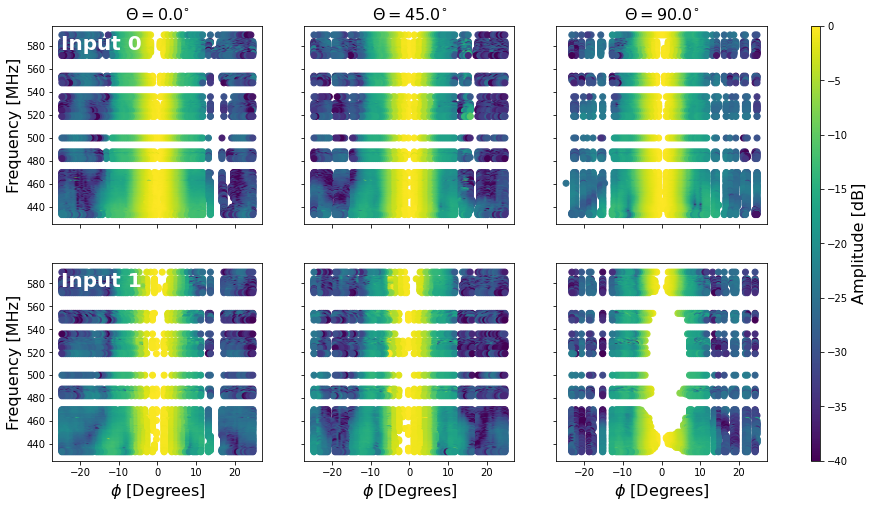

In [ ]:
fig = plt.figure(figsize=(16,8))

# Npol flights
chind = pols[0]
for p,pp in enumerate(Npolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')

plt.show()

[538, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632, 633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700, 702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803, 805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852, 853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866, 867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902, 903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931, 932, 933, 935, 936, 937, 938, 939]


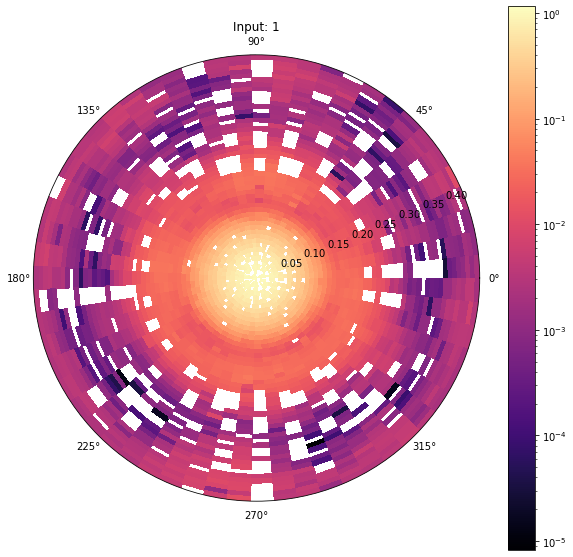

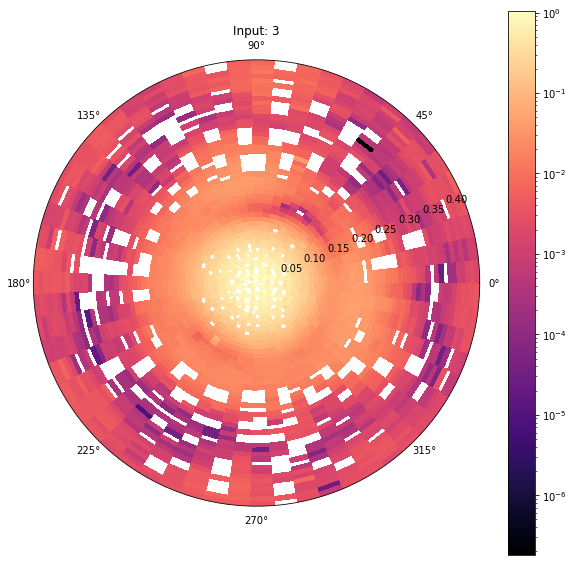

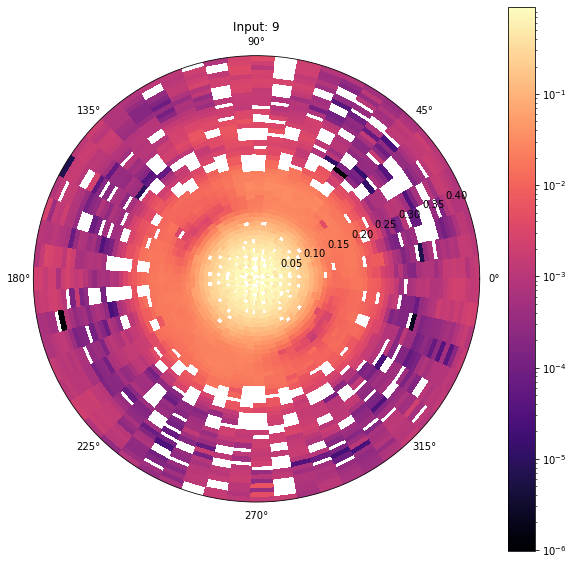

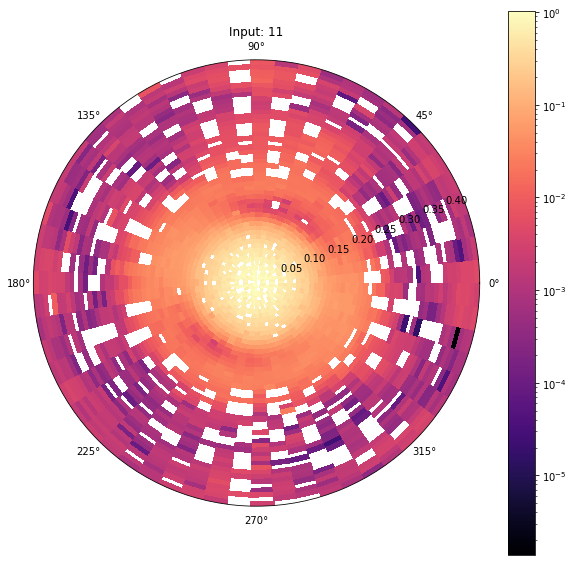

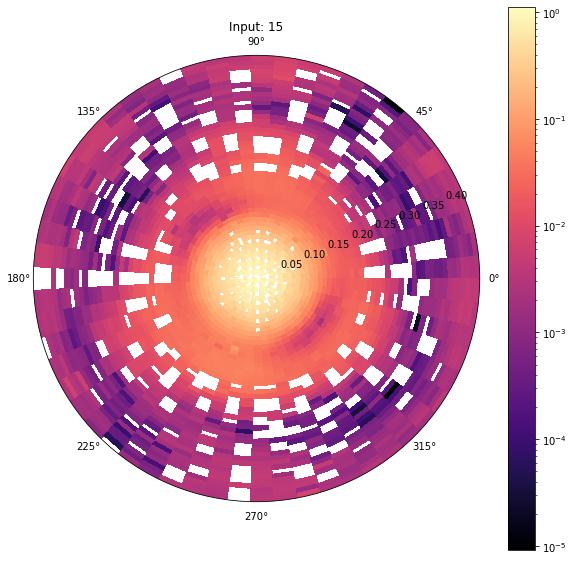

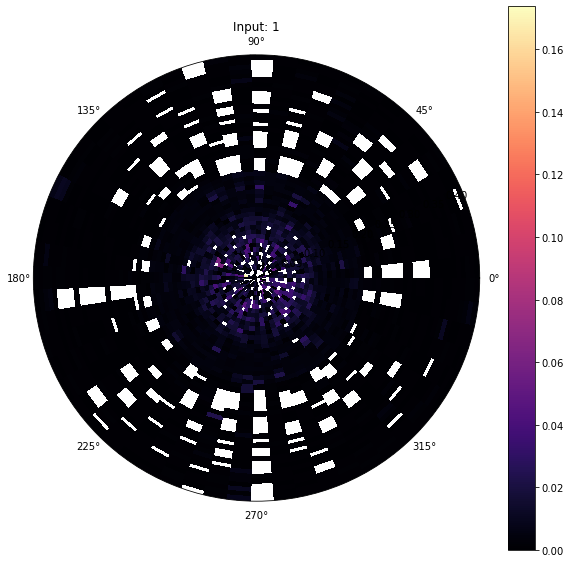

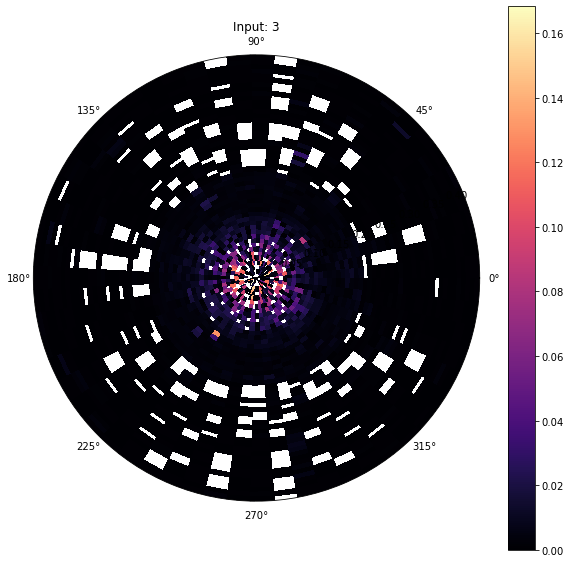

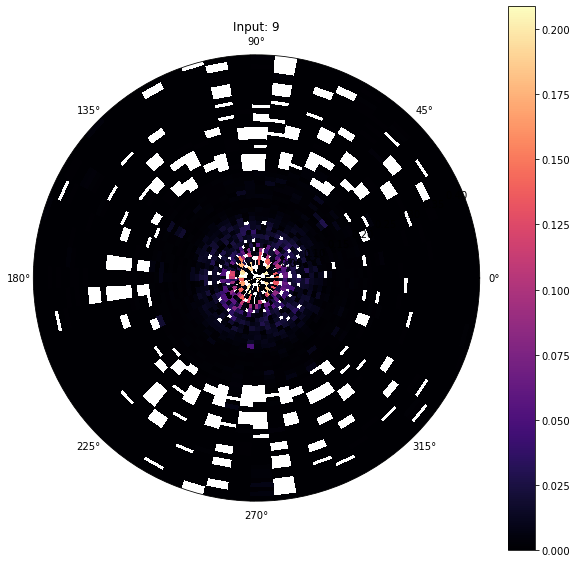

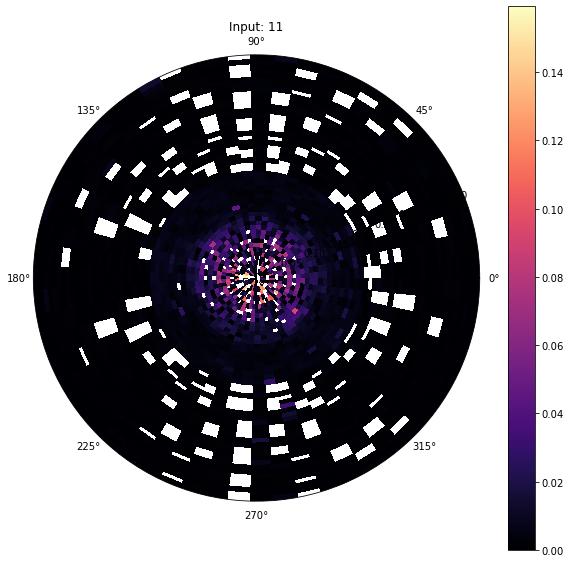

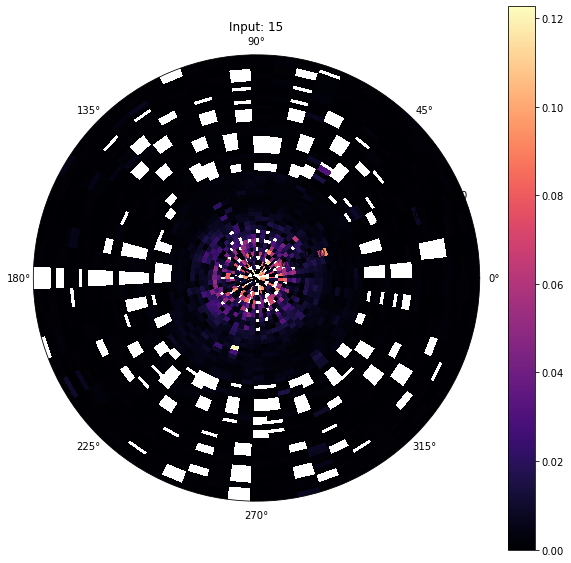

In [4]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

0.10649466622338281
59


0.7853981633974483 0.07099644414892188 0.8563946075463702 0.7144017192485264
7 36
7 36
[0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254 0.79782254
 0.79782254 0.79782254]
[3.88616786 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786
 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786
 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786
 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786
 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786 3.88616786
 3.88616786 3.8861

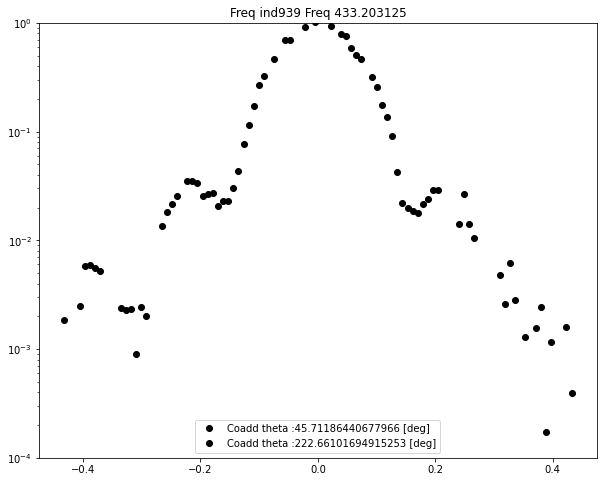

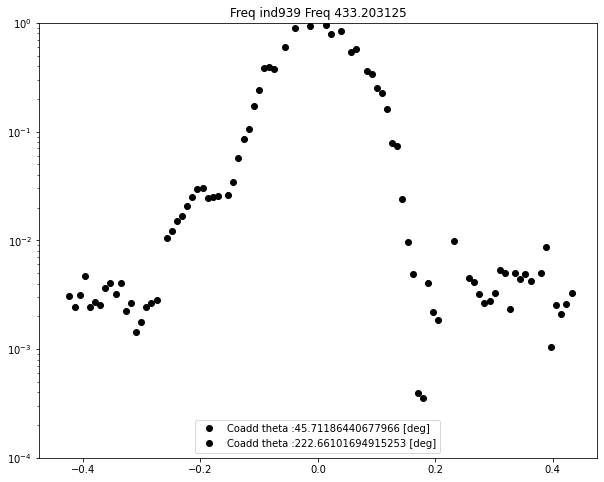

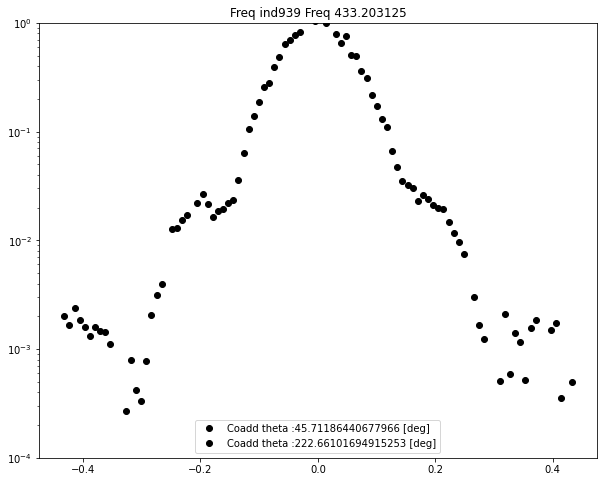

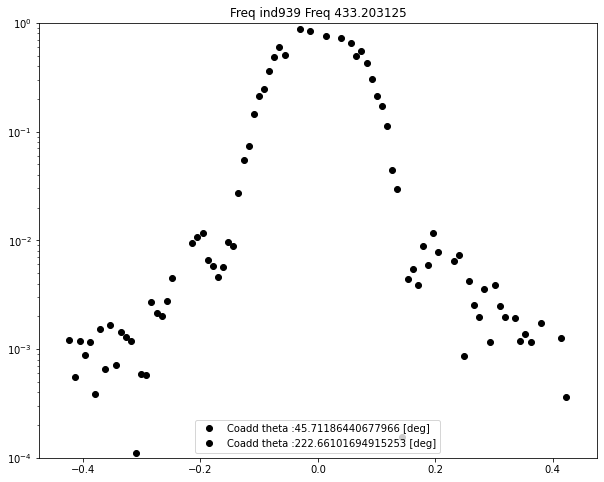

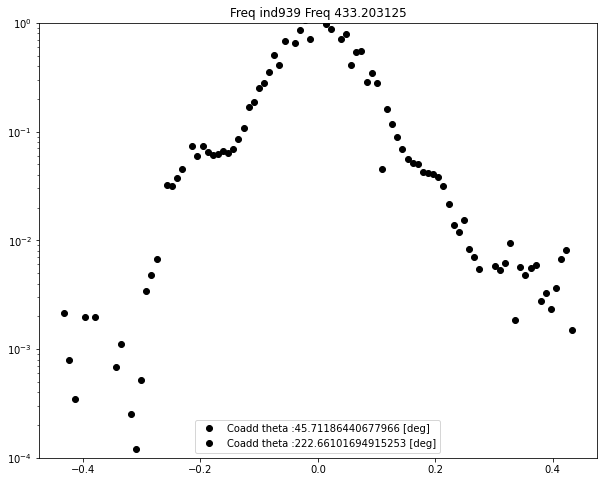

In [69]:

for i,chind in enumerate(pols): 
    fig = plt.figure(figsize=(10,8))

    plt.semilogy(ptest.d1_centers_grid[col1,:,chind],ptest.V_LC_operation[col1,:,0,chind],'o',
             color='black',label='Coadd theta :'+str(np.degrees(ptest.d0_centers_grid[col1,0,chind]))+' [deg]')
    plt.semilogy(-1.0*ptest.d1_centers_grid[col2,:,chind],ptest.V_LC_operation[col2,:,0,chind],'o',
             color='black',label='Coadd theta :'+str(np.degrees(ptest.d0_centers_grid[col2,0,chind]))+' [deg]')
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    #plt.xlim(-1*sz,sz)
    plt.legend(loc='lower center')
    plt.title('Freq ind'+str(find)+' Freq '+str(freqs[find]))
    plt.show()



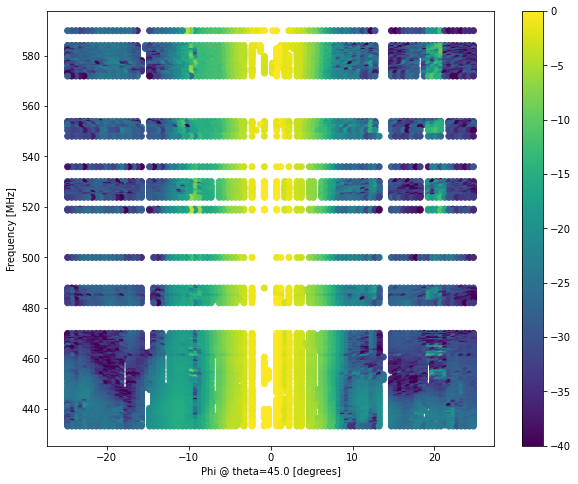

In [70]:
# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0
chind = pols[1]

fig = plt.figure(figsize=(10,8))
for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    plt.scatter(np.degrees(ptest.d1_centers_grid[col1,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col1,:,0,chind])),vmin=-40,vmax=0)
    plt.scatter(np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind]),f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=-40,vmax=0)
plt.ylabel('Frequency [MHz]')
plt.xlabel('Phi @ theta=45.0 [degrees]')
plt.colorbar()
plt.show()


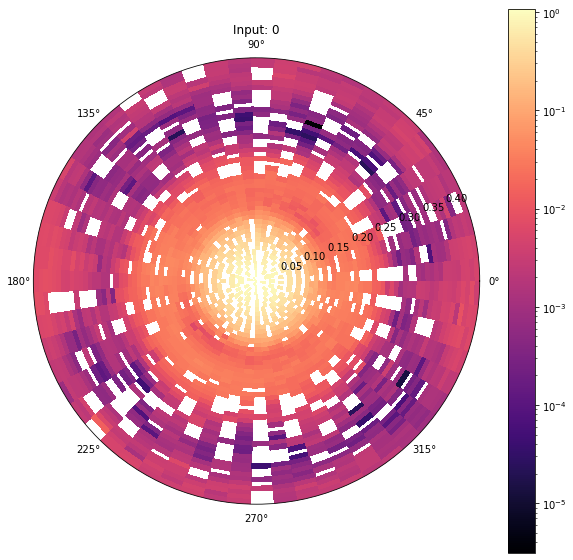

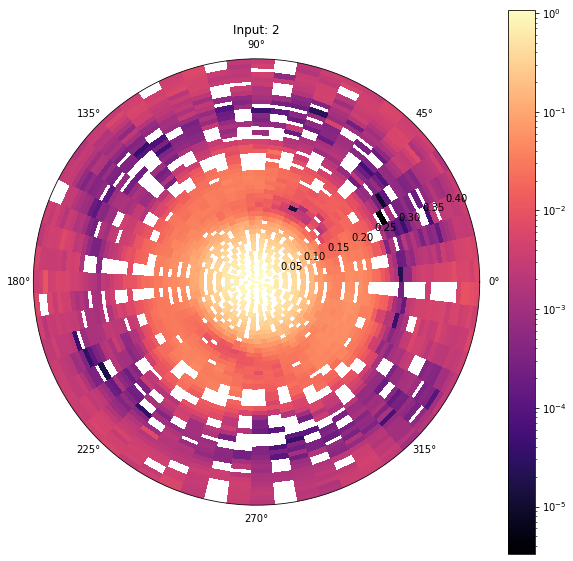

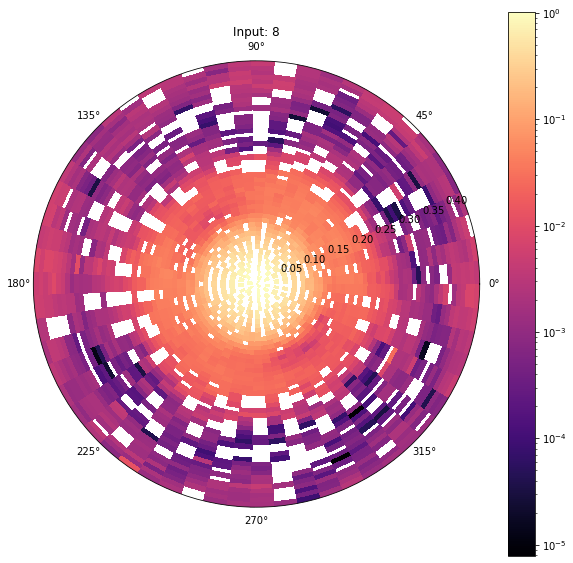

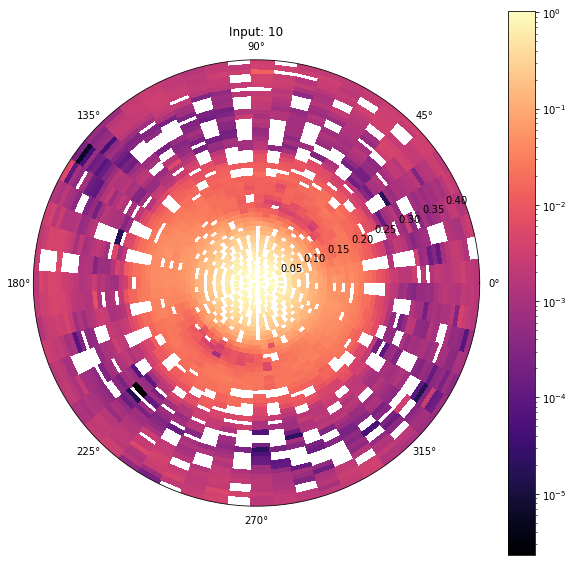

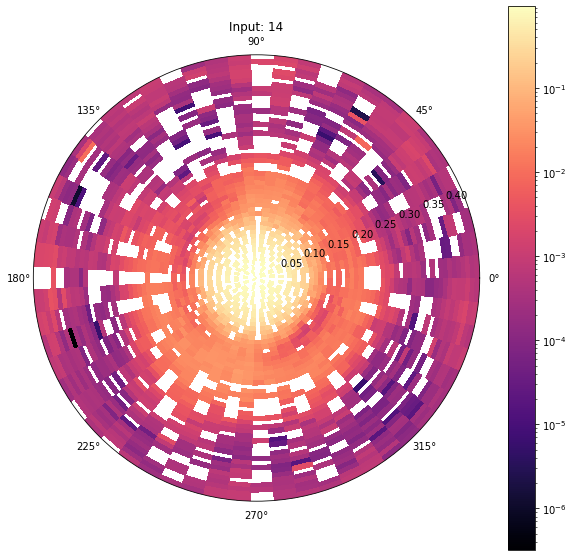

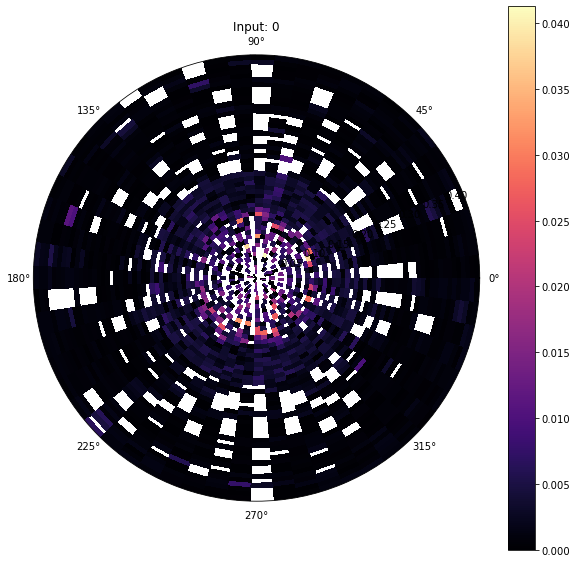

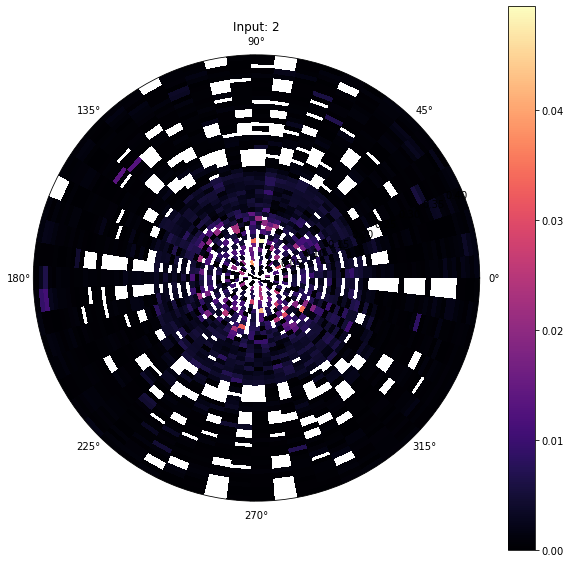

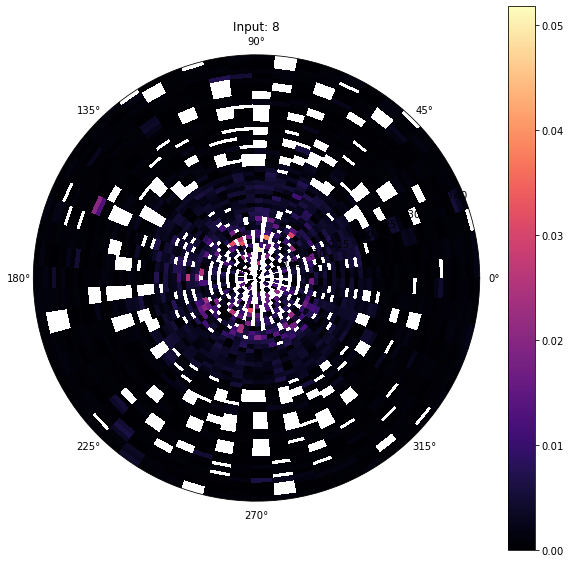

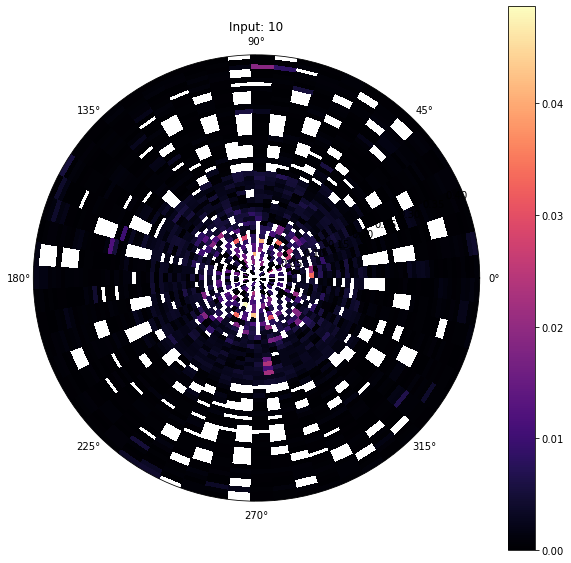

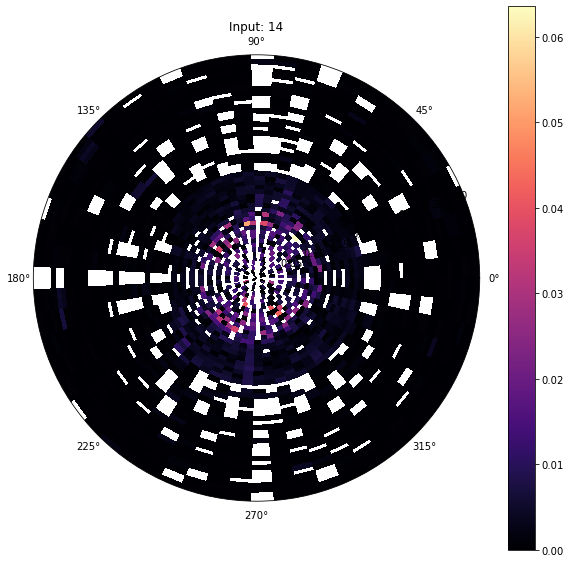

In [10]:
# set which pol:
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    #plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
    #           c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation[:,:,0,chind],cmap=cm.magma,norm=LogNorm())
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                   ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

0.008726646259971648


In [ ]:
def get_polar_slice(theta,phi,amps,sliceval, slicedir='v'):   
    # this gradually increases the tolerance until it finds something
    tol = abs(phi[0,1] - phi[0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]

# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



# CARTESIAN - Read in a single co-added beam pickle and plot maps, slices

In [ ]:
fig = plt.figure(figsize=(20,7))
plt.subplot(2,5,1)


copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
print(freqs[900])
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,1+i)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    
    
# set which pol:
copoldir = 'N'
pols = N_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    plt.subplot(2,5,5+i+1)
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,vmin=1E-4,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    

plt.show()

    
    



[538, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632, 633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700, 702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803, 805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852, 853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866, 867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902, 903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931, 932, 933, 935, 936, 937, 938, 939]


<ipython-input-4-2ff729485fc1>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


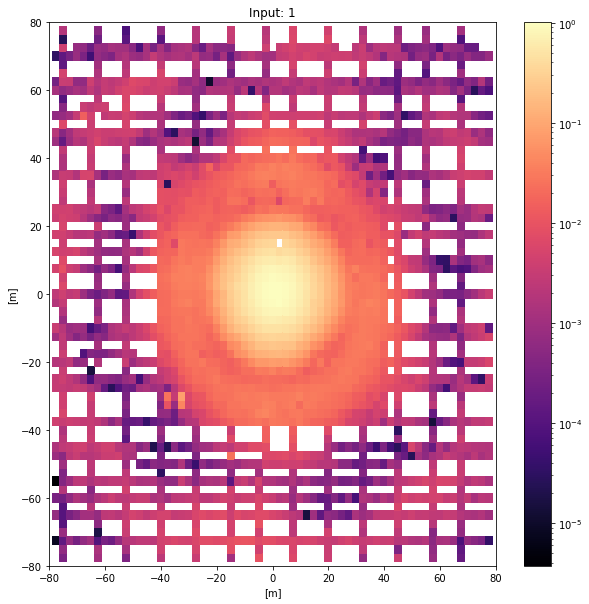

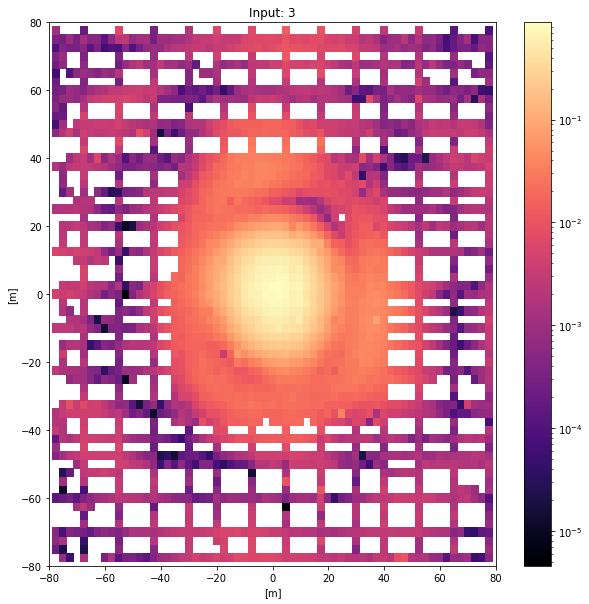

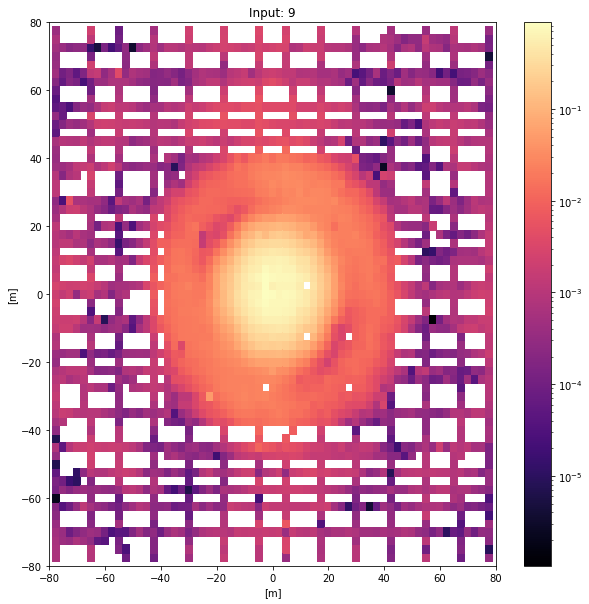

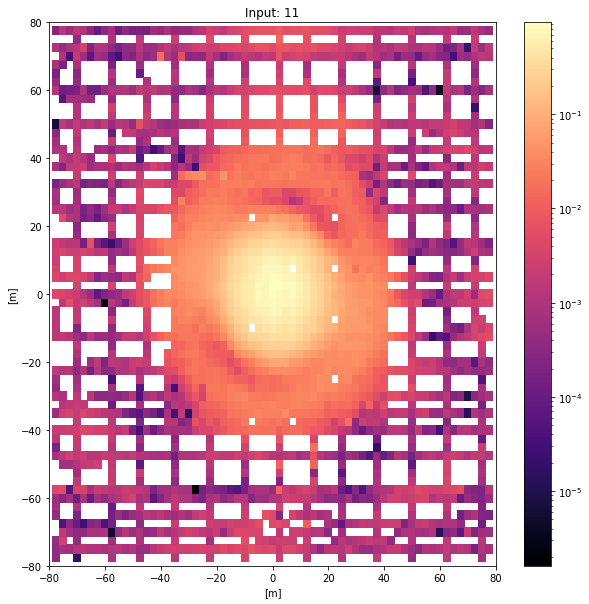

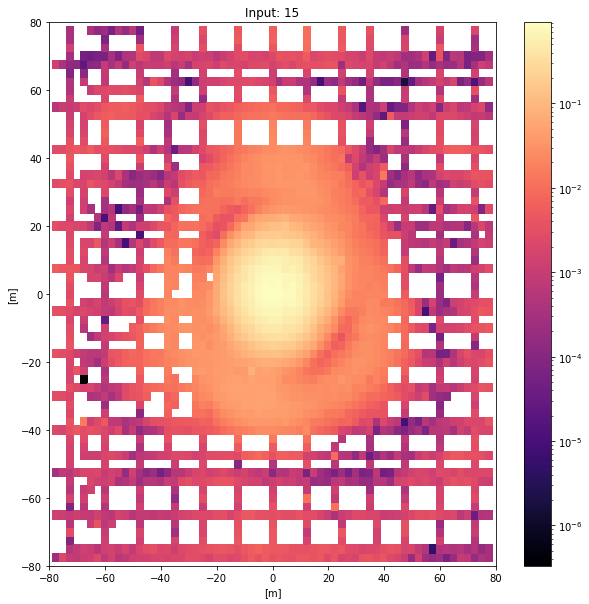

<ipython-input-4-2ff729485fc1>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


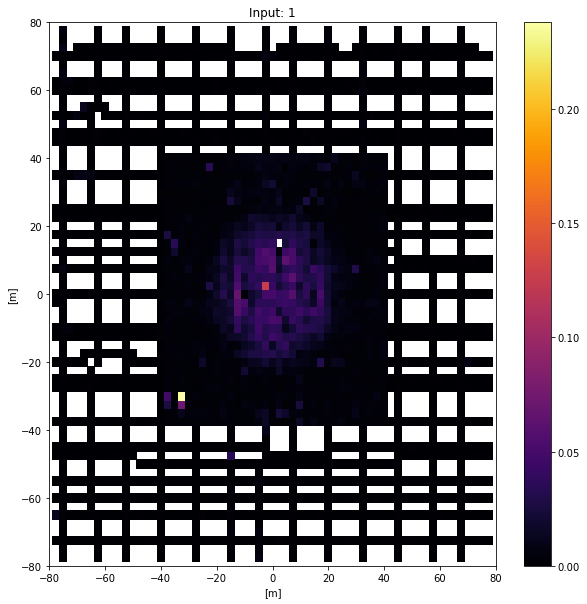

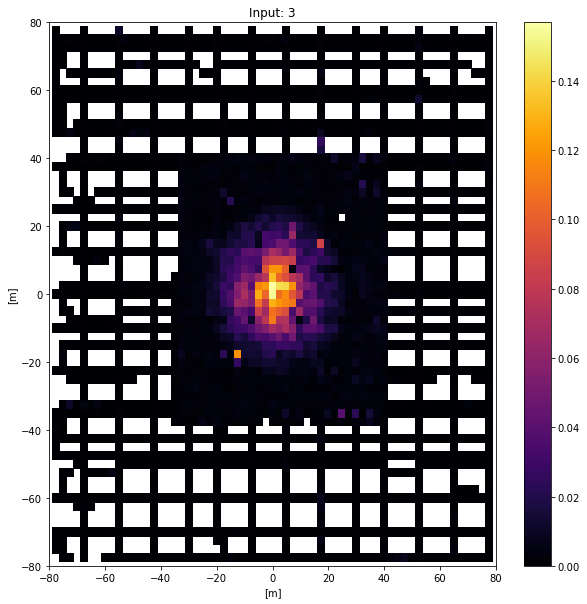

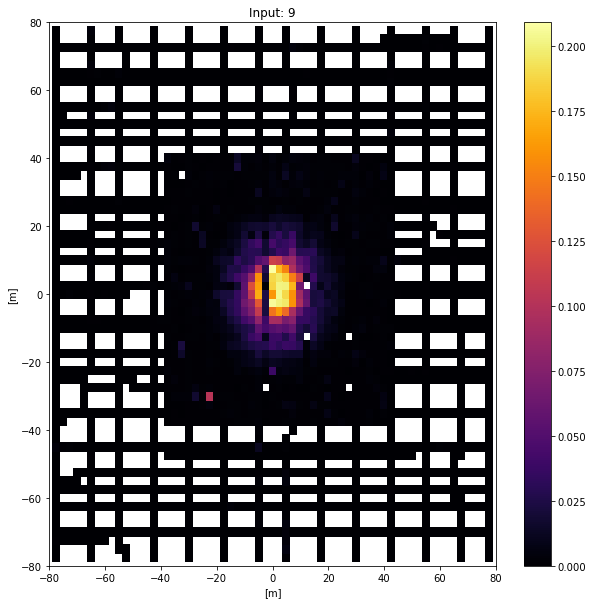

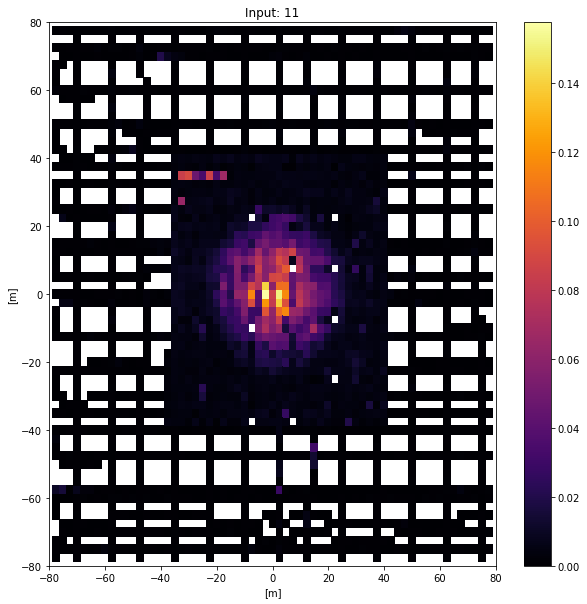

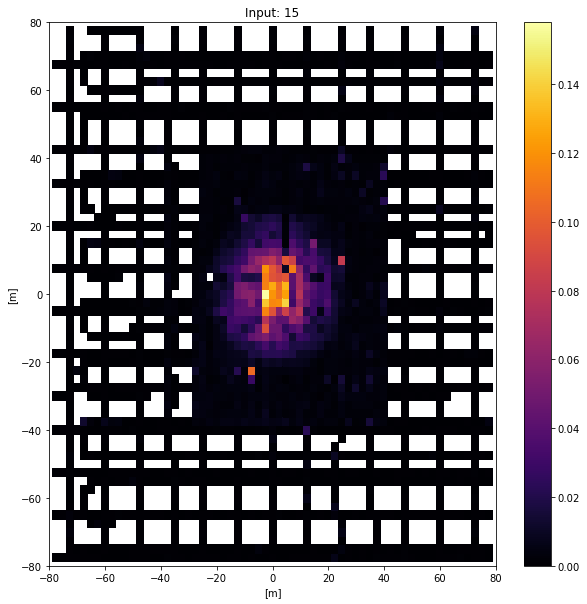

<ipython-input-4-2ff729485fc1>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


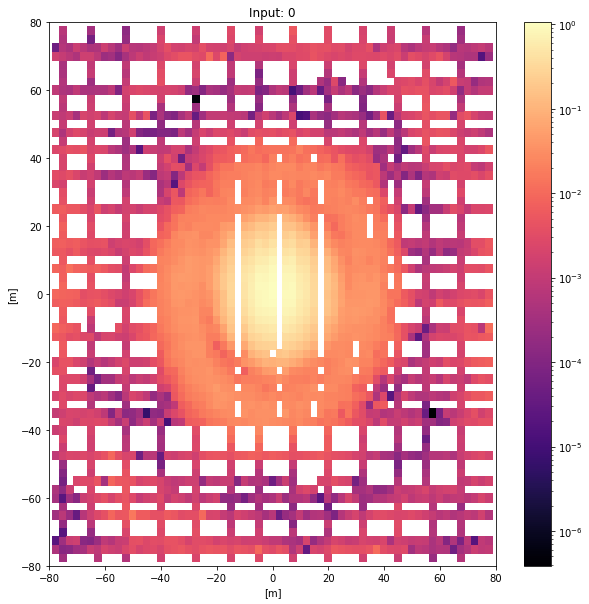

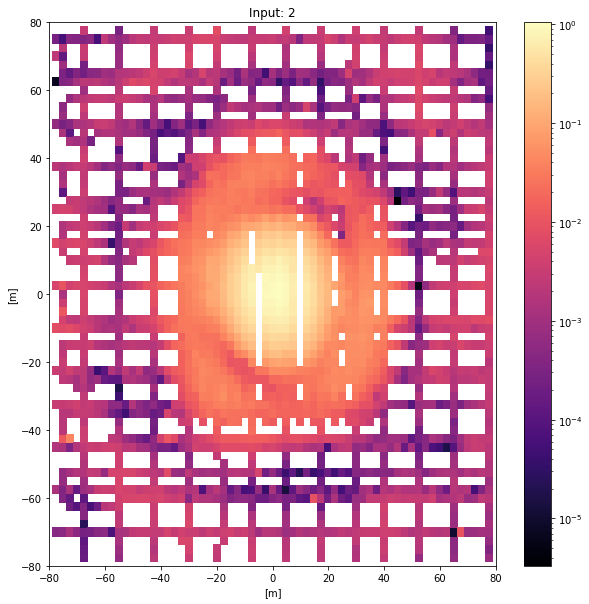

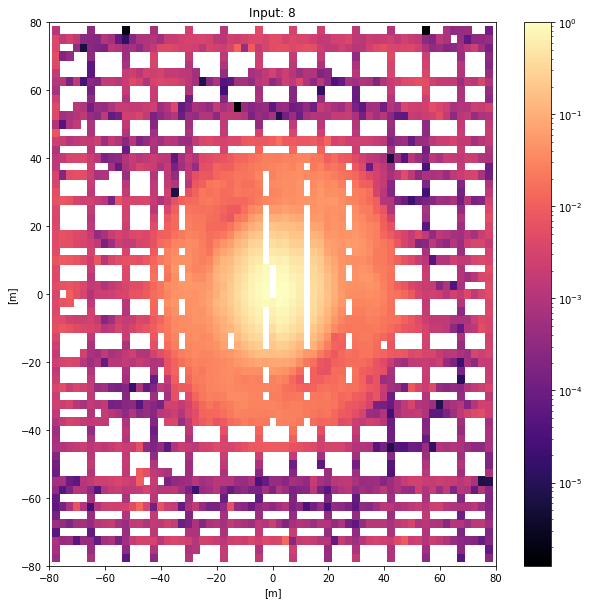

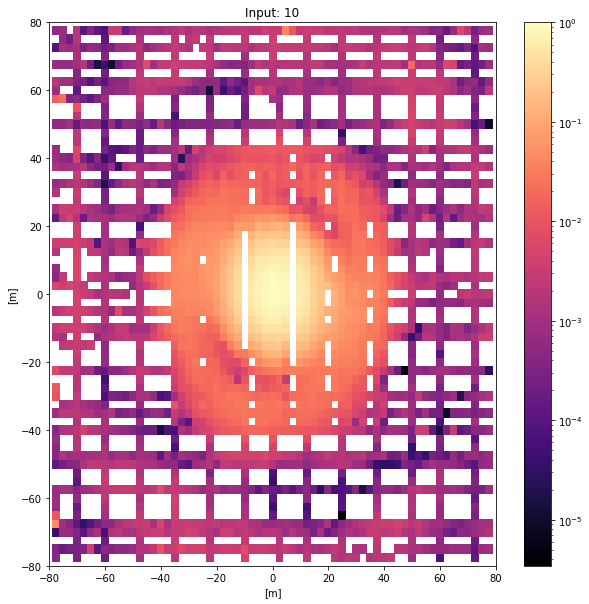

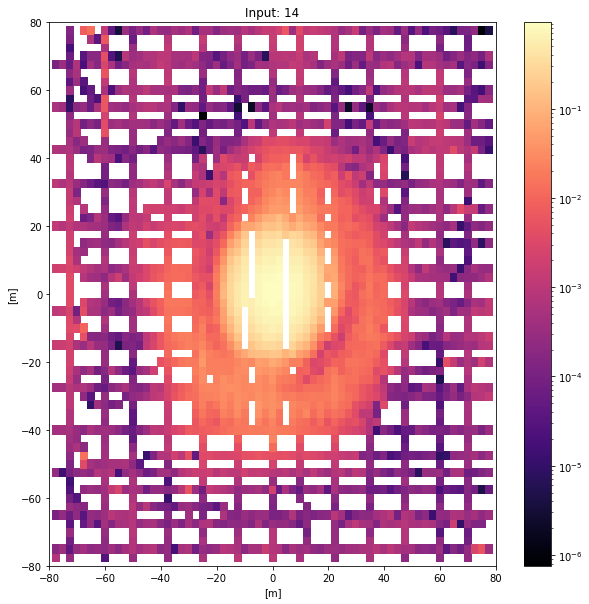

<ipython-input-4-2ff729485fc1>:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


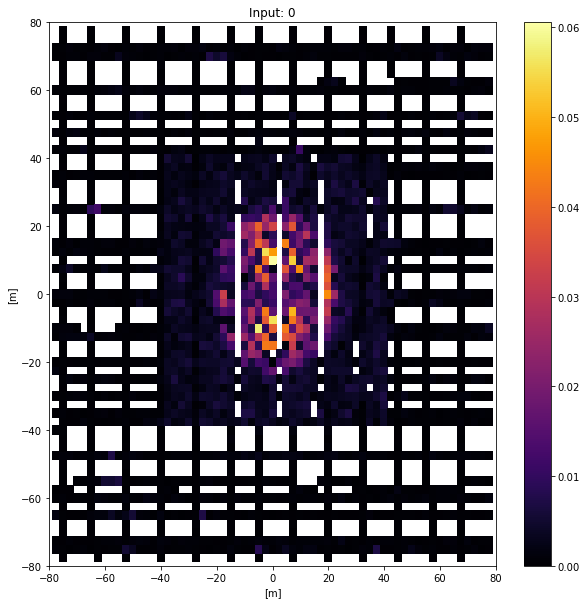

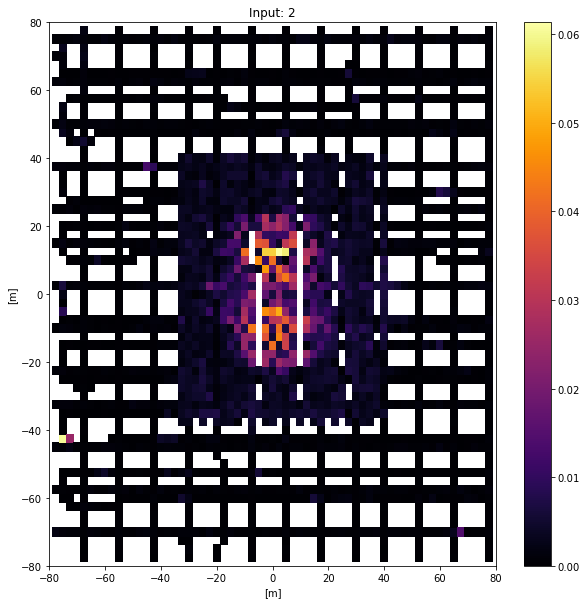

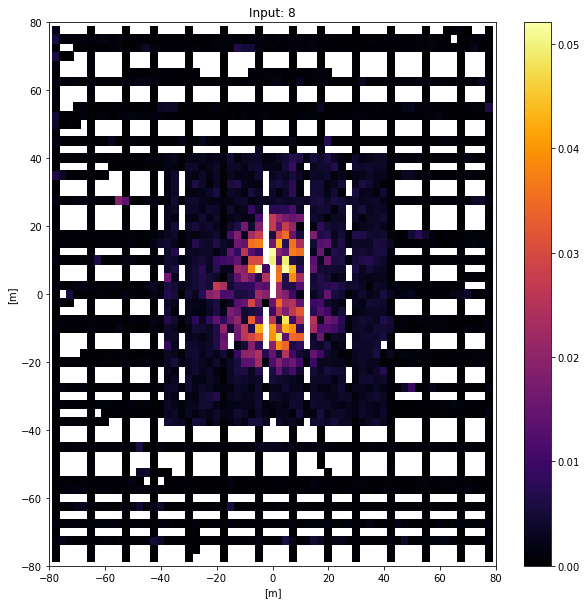

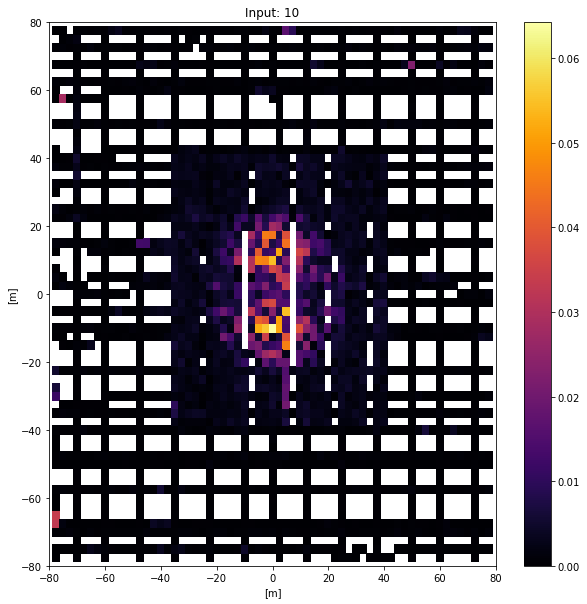

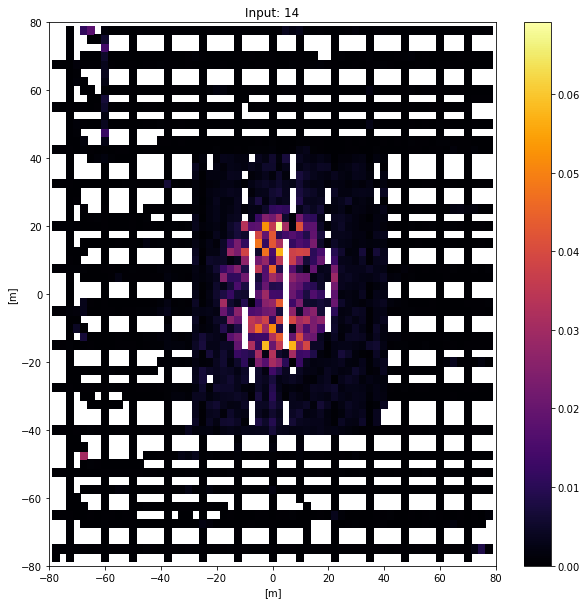

In [4]:
print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    



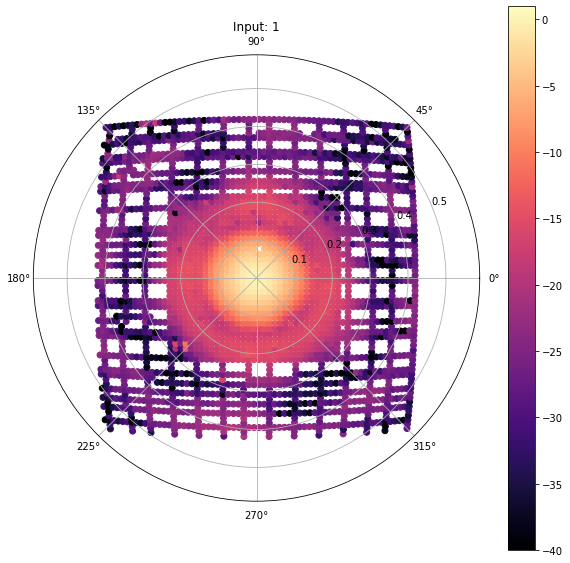

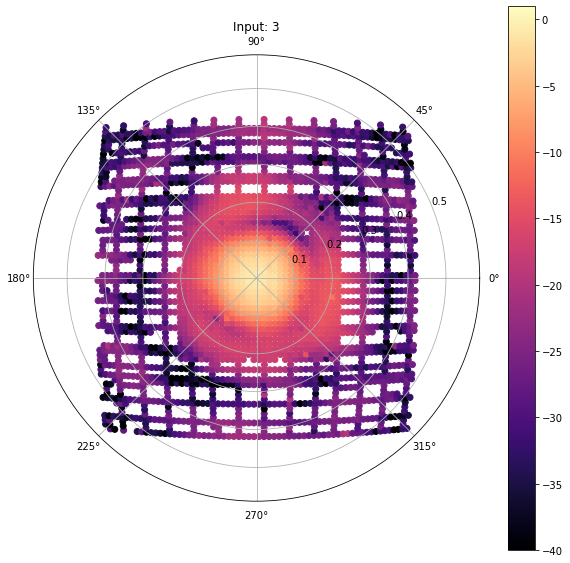

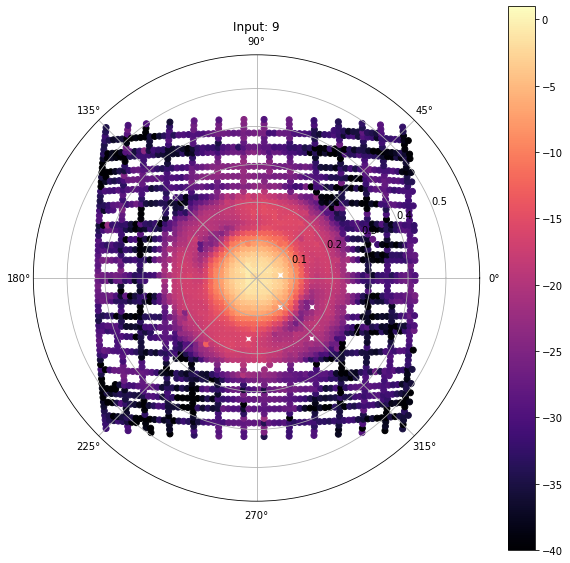

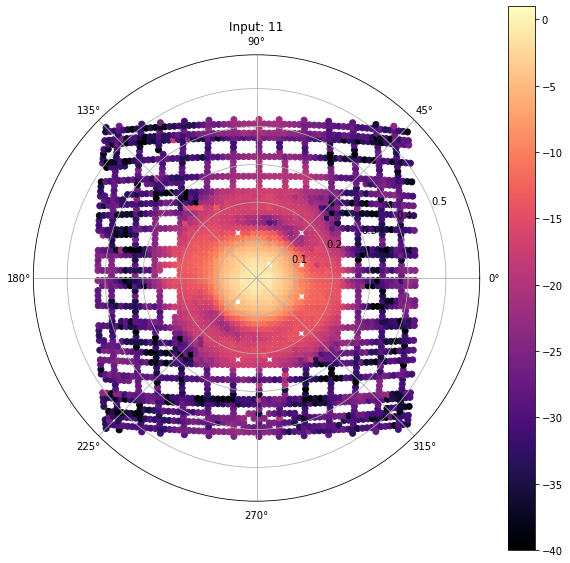

<ipython-input-7-918720b38453>:21: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')


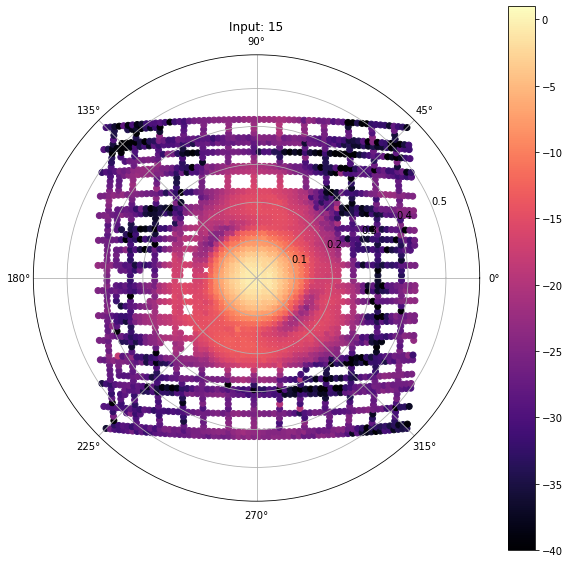

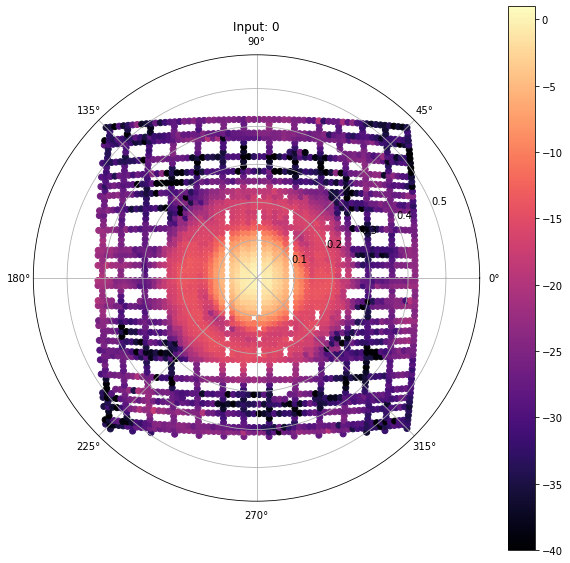

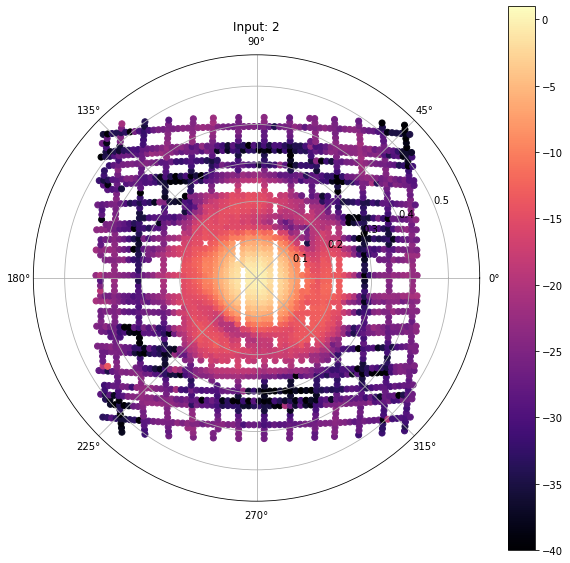

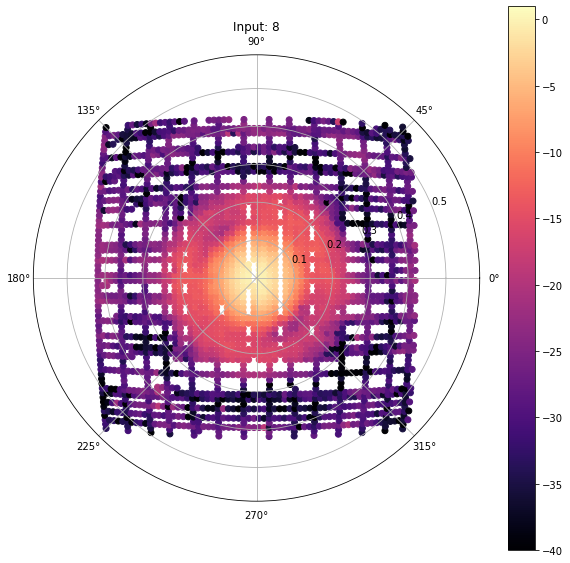

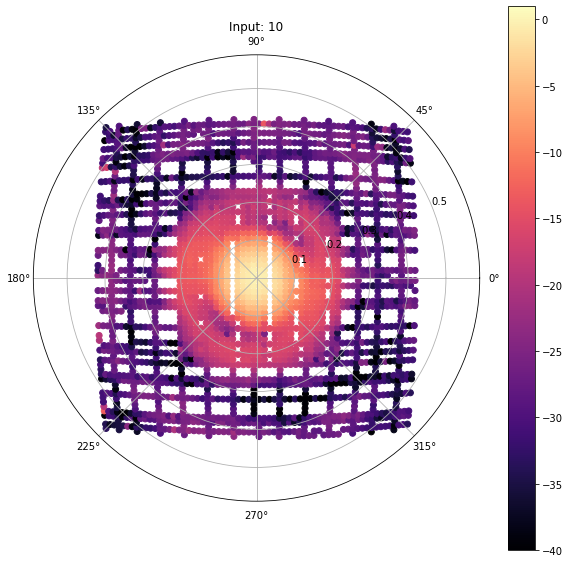

<ipython-input-7-918720b38453>:44: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')


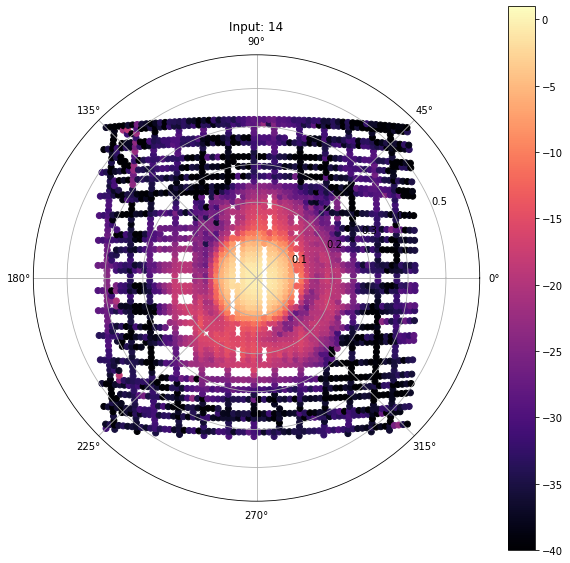

In [7]:



# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
z=177.
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
copoldir = 'E'
pols = E_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = ptest.x_centers_grid[:,:,chind]
    y = ptest.y_centers_grid[:,:,chind]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(x / np.sqrt(x**2 + y**2))
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(phi,theta,
               c=10*np.log10(np.abs(ptest.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

Text(0.5, 0.98, 'Freq ind900 Freq 448.4375')

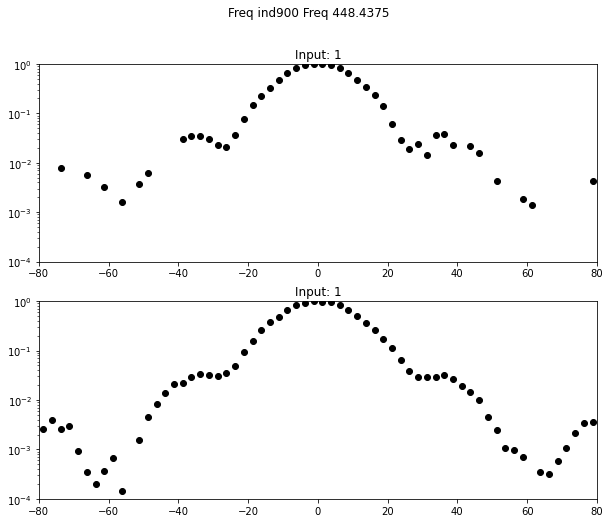

In [9]:
# plot slice through the co-added beams above

# set which pol:
copoldir = 'N'
pols = N_pols
f_intern = 0 # only one frequency per file, this is always 0

find = 900
picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    beam_coad = pickle.load(inp)
    
xx = 0
chind = pols[0]
colx = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'v')
coly = get_slice(beam_coad,beam_coad.V_LC_operation[:,:,0,chind],xx,'h')

fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],'o',
             label='Coadd x :'+str(beam_coad.x_centers_grid[colx,0,0]),color='black')
plt.title('Input: '+str(chind))
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
#plt.legend(loc='lower center')
plt.subplot(2,1,2)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],'o',
             label='Coadd  y :'+str(beam_coad.y_centers_grid[0,coly,0]),color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.title('Input: '+str(chind))
#plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))



In [20]:
Npolflights = ['618','619','623','625','646','647','533','536']
Epolflights = ['620','648','649','535']

pflights=Npolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(pflights):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]

618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of big ass loop is: 2023-11-14 14:59:41.617004
end of chan/freq loop is: 2023-11-14 14:59:44.567287       


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:329: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl'>
start of big ass loop is: 2023-11-14 14:59:52.436255
end of chan/freq loop is: 2023-11-14 14:59:57.197421       
623 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY623_20211021T203206Z_ver_20231012T014921_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY623_20211021T203206Z_ver_20231012T014921_concat.pkl'>
start of big ass loop is: 2023-11-14 15:00:06.972710
end of chan/freq loop is: 2023-11-14 15:00:12.622871       
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

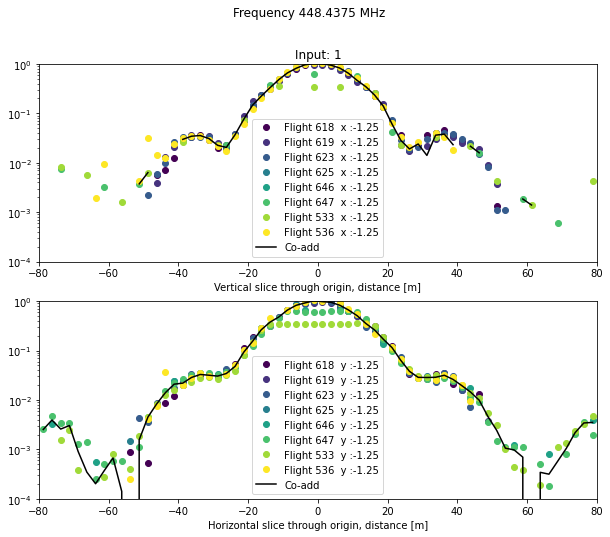

In [11]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.semilogy(beam.y_centers_grid[colx,:,0],flightarr[colx,:,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  x :'+str(beam.x_centers_grid[colx,0,0]))
    plt.title('Input: '+str(chind))
plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
             label='Co-add',color='black')
plt.ylim(0.0001,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.semilogy(beam.x_centers_grid[:,coly,0],flightarr[:,coly,chind,i],'o',
             color=colors[i],label='Flight '+str(p)+'  y :'+str(beam.y_centers_grid[0,coly,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

<ipython-input-21-89d812c7e182>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
<ipython-input-21-89d812c7e182>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],


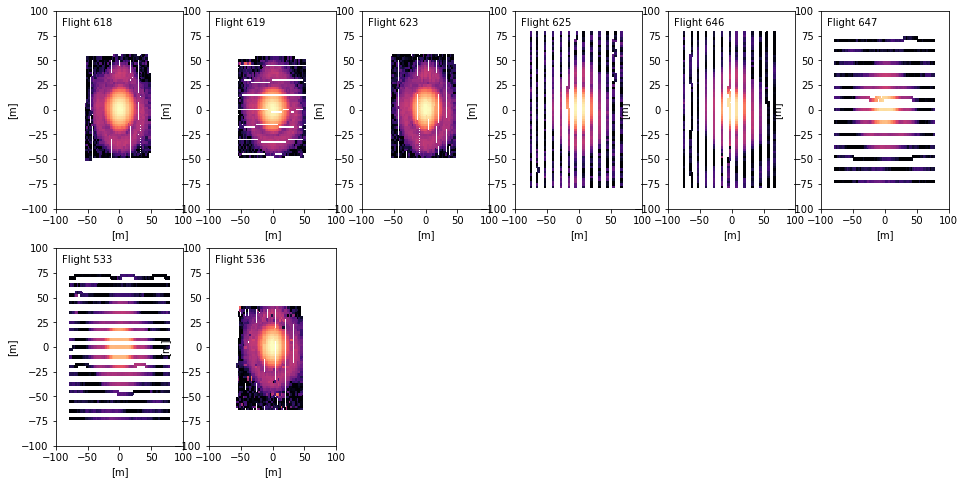

In [21]:
fig = plt.figure(figsize=(16,8))

# Npol flights
chind = pols[0]
for p,pp in enumerate(Npolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')

plt.show()

Text(0.5, 0.98, 'Frequency 448.4375 MHz')

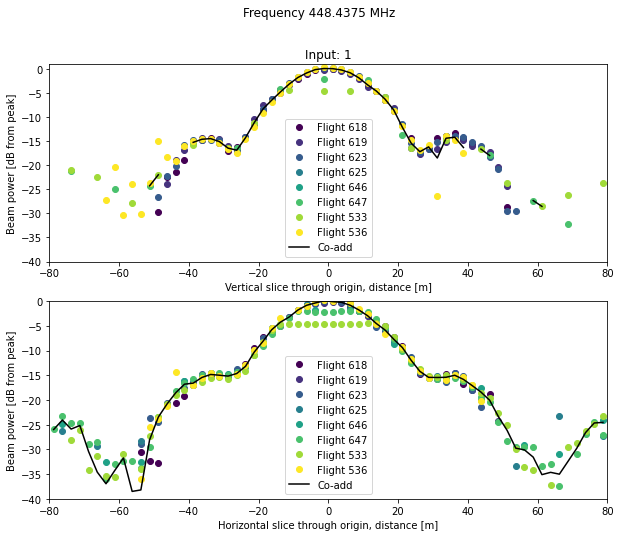

In [12]:
colors=pu.cm_to_discrete('viridis', len(pflights))

xx = 0
chind = pols[0]
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
for i,p in enumerate(pflights):
    plt.plot(beam.y_centers_grid[colx,:,0],10*np.log10(abs(flightarr[colx,:,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.title('Input: '+str(chind))
plt.plot(beam_coad.y_centers_grid[colx,:,chind],10*np.log10(np.abs(beam_coad.V_LC_operation[colx,:,0,chind])),
             label='Co-add',color='black')
plt.ylim(-40,1)
plt.xlim(-1*sz,sz)
plt.xlabel('Vertical slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')

plt.subplot(2,1,2)
for i,p in enumerate(pflights):
    plt.plot(beam.x_centers_grid[:,coly,0],10*np.log10(abs(flightarr[:,coly,chind,i])),'o',
             color=colors[i],label='Flight '+str(p))
    plt.ylim(-40,0)
    plt.xlim(-1*sz,sz)
plt.plot(beam_coad.x_centers_grid[:,coly,0],10*np.log10(abs(beam_coad.V_LC_operation[:,coly,0,chind])),
             label='Co-add',color='black')
plt.xlabel('Horizontal slice through origin, distance [m]')
plt.ylabel('Beam power [dB from peak]')
plt.legend(loc='lower center')
plt.suptitle('Frequency '+str(freqs[find])+' MHz')

In [16]:
pflights=Epolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(Epolflights):
    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]





620 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl'>
start of big ass loop is: 2023-11-14 14:56:21.703520
end of chan/freq loop is: 2023-11-14 14:56:24.503303       
648 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl'>
start of big ass loop is: 2023-11-14 14:56:33.106168
end of chan/freq loop is: 2023-11-14 14:56:38.113969       
649 E [0, 2, 8, 10, 14] [1, 3, 9, 11, 15] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY649_20211022T194308Z_ver_20231012T033021_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY649_20211022T194308Z_

<ipython-input-17-63cff66c1ed0>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
<ipython-input-17-63cff66c1ed0>:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],


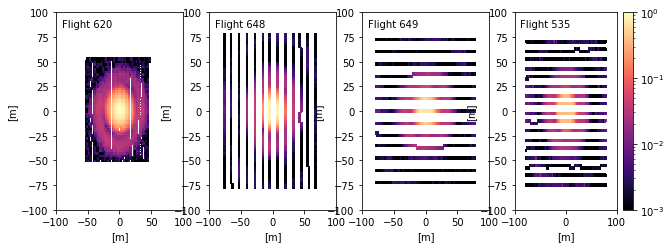

In [17]:
fig = plt.figure(figsize=(16,8))
pols=E_pols

# Epol flights
chind = pols[0]
for p,pp in enumerate(Epolflights):
    plt.subplot(2,6,p+1)
    plt.pcolormesh(beam.x_centers_grid[:,:,0],beam.y_centers_grid[:,:,0],
               np.abs(flightarr[:,:,chind,p]),cmap=cm.magma,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-100,100)
    plt.ylim(-100,100)
    plt.text(-90,85,'Flight '+str(pp))
    plt.xlabel('[m]')
    plt.ylabel('[m]')
plt.colorbar()
plt.show()

# Gaussian fit the co-added maps above

In [18]:
#### LEAST SQUARES FITTING #####


#restr = 18
# read in all N pol co-adds

print(good_freqs)
G_popt = np.zeros([16,1024,6])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

# set which pol:
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x

copoldir = 'E'
pols = E_pols

for f,find in enumerate(good_freqs):

    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        #gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
        gi = np.where(np.isfinite(mbV))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        G_popt[chind,find,:] = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x


[538, 553, 554, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632, 633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700, 702, 703, 705, 706, 707, 719, 720, 768, 799, 801, 802, 803, 805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852, 853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866, 867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902, 903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931, 932, 933, 935, 936, 937, 938, 939]


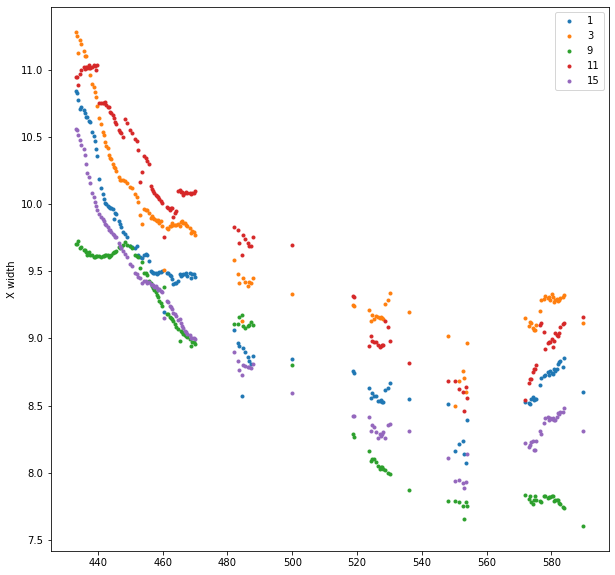

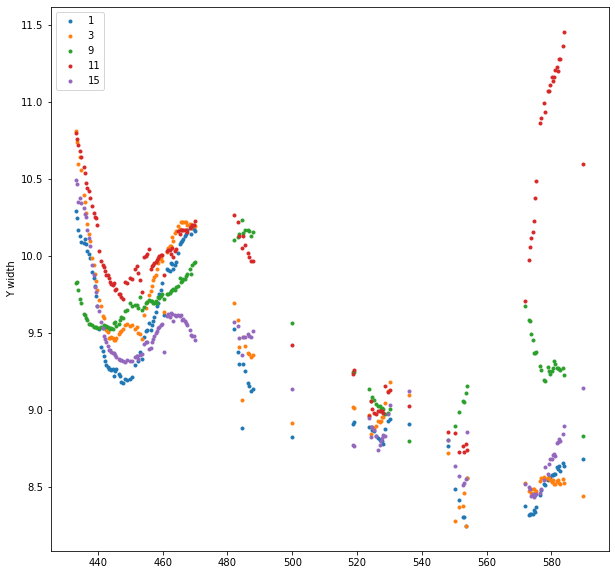

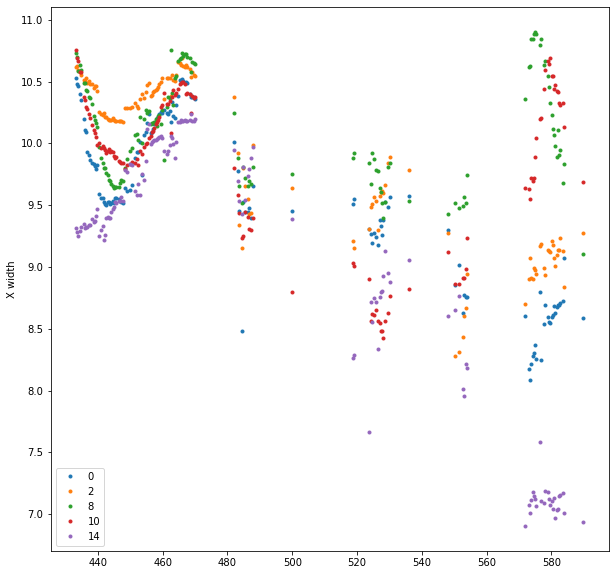

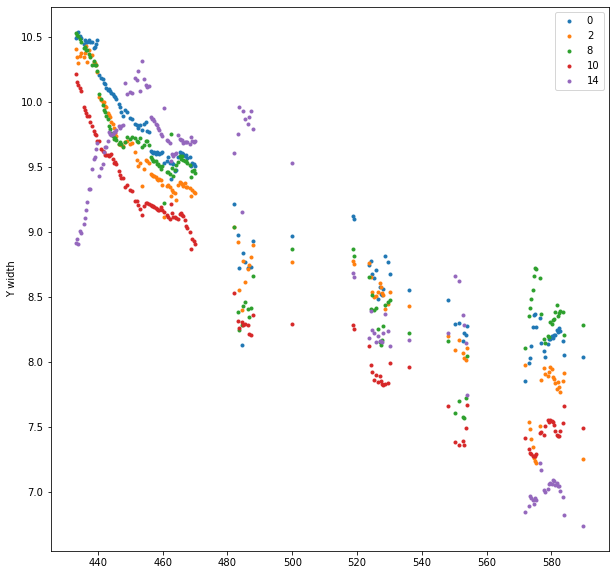

In [19]:
pols = N_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,2],marker='.',linestyle='None',label=str(pp))
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
for p,pp in enumerate(pols):
    plt.plot(freqs[good_freqs],G_popt[pp,good_freqs,4],marker='.',linestyle='None',label=str(pp))
plt.ylabel('Y width')
plt.legend()
plt.show()

In [ ]:
################################################################
#### EMCEE EMCEE FITTING OF the coadded maps for FWHM etc ######
################################################################
import emcee
import corner


In [64]:


# This combines all of the emcee stuff into functions:
### ONLY NEED TO RUN THIS ONCE #########
## Fit the coadded maps with a Gaussian, emcee it for errors, and save that



def model(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    #xsig,ysig = P
    xx = ((x-x0)**2)/(2*(xsig**2))
    yy = ((y-y0)**2)/(2*(ysig**2))
    return amp*np.exp(-1.0*(xx + yy))+c

def lnlike(P,x,y,V,Verr):
    LnLike = -0.5*np.nansum(((model(P,x,y)-V)/Verr)**2)
    return LnLike

def lnprior(P):
    amp,x0,xsig,y0,ysig,c=P
    if x0>-1 and x0<1 and y0>-1 and y0<1 and c<0.1 and xsig>5.0 and xsig<12.0 and ysig>5.0 and ysig<12.0 and amp>-1.5 and amp<1.5:
        return 0.0
    else:
        return -np.inf

def lnprob(P,x,y,V,Verr):
    lp = lnprior(P)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(P,x,y,V,Verr) #recall if lp not -inf, its 0, so this just returns likelihood



def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state


def get_ml_solns(mbx,mby,mbV,mbVerr,gi):
    pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])
    nwalkers = 500
    data = (mbx[gi],mby[gi],mbV[gi],mbVerr[gi])
    niter = 3000
    ndim = len(pG)
    p0 = [np.array(pG) + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
    samples = sampler.flatchain
    try:
        tau = sampler.get_autocorr_time()
        print(tau)
    except: 'TAU DIDNT WORK'

    #for i in range(0,ndim):
    #    plt.hist(samples[:,i],bins=30)
    #    plt.axvline(samples[np.argmax(sampler.flatlnprobability),i],color='red')
    #    plt.show()
    #    print(i,samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))
       
    fits = np.zeros([ndim,4])
    for i in np.arange(ndim):
        results = np.percentile(samples[:, i], [16, 50, 84])
        fits[i,0] = results[1] # 50% error bars
        fits[i,1] = np.std(samples[:,i]) # use the stdd of the dist.
        fits[i,2] = np.diff(results)[0]
        fits[i,3] = np.diff(results)[1]
    return fits

In [51]:
copoldir = 'N'
pols = N_pols

find = good_freqs[0]
chind = pols[0]

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


mbx = ptest.x_centers_grid[:,:,chind].flatten()
mby = ptest.y_centers_grid[:,:,chind].flatten()
mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
mbVerr = ptest.V_LC_operation_err[:,:,0,chind].flatten()
#gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & (mbVerr!=0))[0]
gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & (mbVerr!=0) & (np.abs(mbx)<20) & (np.abs(mby)<20))[0]

In [91]:
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-6])
plt.scatter(mbx[gi],mby[gi],c=mbV[gi])
plt.show()
    
plt.scatter(mbx,mby,c=model(pG,mbx,mby))
plt.show()

print('Output of LNLIKE ',lnlike(pG,mbx[gi],mby[gi],mbV[gi],mbVerr[gi])) 

print('LNPRIOR',lnprior(pG))

nwalkers = 500
data = (mbx[gi],mby[gi],mbV[gi],mbVerr[gi])
niter = 3000
ndim = len(pG)
#pos = pG + 1e-4 * np.random.randn(32, 3)
#nwalkers, ndim = pos.shape

p0 = [np.array(pG) + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples
);

samples = sampler.flatchain

print(samples.shape)

for i in range(0,ndim):
    #plt.hist(flat_samples[:,i],bins=30)
    errs = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(errs)
    print(i, errs) 
    print(i, errs[1],q[0], q[1])
    #plt.axvline(flat_samples[np.argmax(sampler.flatlnprobability),i],color='red')
    #plt.show()
    #print('i',G_popt.x[i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))

DONE


In [ ]:
## Compare to gaussian fit averages

coadded = np.load('/hirax/GBO_Analysis_Outputs/Averaged_2dGauss_and_Airy_Param.npz')

        
print('iter','lsq','mcmc','mcmcerr')
for i in range(0,ndim):
    print('i',coadded['averaged'][chind,find,i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))
    
for i in range(0,ndim):
    plt.hist(samples[:,i],bins=30)
    plt.axvline(samples[np.argmax(sampler.flatlnprobability),i],color='red')
    plt.show()
    print(i,coadded['averaged'][chind,find,i],samples[np.argmax(sampler.flatlnprobability),i],np.std(samples[:,i]))

In [ ]:
# Let's go crazy and see what happens across 10 frequencies:

emcfits = np.zeros([1024,len(N_pols)+len(E_pols),6,4]) # freq,channel,fits, value/error

# Npols first
copoldir = 'N'
pols = N_pols

for f,find in enumerate(good_freqs[0:5]):
        
    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for c, chind in enumerate(pols[0:1]):
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
        mbVerr = ptest.V_LC_operation_err[:,:,0,chind].flatten()
        #gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & (mbVerr!=0))[0]
        gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & 
                  (mbVerr!=0) & (np.abs(mbx)<20) & (np.abs(mby)<20))[0]
    
        emcfits[find,chind,:,:] = get_ml_solns(mbx,mby,mbV,mbVerr,gi)
## Epols next
copoldir = 'E'
pols = E_pols
for c, chind in enumerate(pols[0:1]):
    for f,find in enumerate(good_freqs[0:5]):

        picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)


        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
        mbVerr = ptest.V_LC_operation_err[:,:,0,chind].flatten()
        #gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & (mbVerr!=0))[0]
        gi = np.where((np.isfinite(mbV)) & (np.isfinite(mbVerr)) & 
                  (mbVerr!=0) & (np.abs(mbx)<20) & (np.abs(mby)<20))[0]
    
        emcfits[find,chind,:,:] = get_ml_solns(mbx,mby,mbV,mbVerr,gi)


#outpkl = '/hirax/GBO_Analysis_Outputs/emcee_fits.pkl'
#with open(outpkl, 'wb') as outp:
#    pickle.dump(emcfits, outp, pickle.HIGHEST_PROTOCOL)
#print('DONE')

pols = N_pols
pp = pols[0]

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,2,0],
             yerr = coadded['averaged'][pp,good_freqs,2,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfits[good_freqs[0:5],pp,2,0],
             yerr=emcfits[good_freqs[0:5],pp,2,1])
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,4,0],
             yerr=coadded['averaged'][pp,good_freqs,4,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfits[good_freqs[0:5],pp,4,0],
            yerr=emcfits[good_freqs[0:5],pp,4,1])
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
pp = pols[0]

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,2,0],
             yerr = coadded['averaged'][pp,good_freqs,2,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfits[good_freqs[0:5],pp,2,0],
             yerr=emcfits[good_freqs[0:5],pp,2,1])
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,4,0],
             yerr=coadded['averaged'][pp,good_freqs,4,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfits[good_freqs[0:5],pp,4,0],
            yerr=emcfits[good_freqs[0:5],pp,4,1])
plt.ylabel('Y width')
plt.legend()
plt.show()

In [ ]:
### check results from full run #####

with open('/hirax/GBO_Analysis_Outputs/emcee_fits.pkl', 'rb') as inp:
            emcfile = pickle.load(inp)
pols = N_pols
pp = pols[0]

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,2,0],
             yerr = coadded['averaged'][pp,good_freqs,2,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfile[good_freqs[0:5],pp,2,0],
             yerr=emcfile[good_freqs[0:5],pp,2,1])
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,4,0],
             yerr=coadded['averaged'][pp,good_freqs,4,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfile[good_freqs[0:5],pp,4,0],
            yerr=emcfile[good_freqs[0:5],pp,4,1])
plt.ylabel('Y width')
plt.legend()
plt.show()

pols = E_pols
pp = pols[0]

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,2,0],
             yerr = coadded['averaged'][pp,good_freqs,2,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfile[good_freqs[0:5],pp,2,0],
             yerr=emcfile[good_freqs[0:5],pp,2,1])
plt.ylabel('X width')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
plt.errorbar(freqs[good_freqs],coadded['averaged'][pp,good_freqs,4,0],
             yerr=coadded['averaged'][pp,good_freqs,4,1],marker='.',linestyle='None',label=str(pp))
plt.errorbar(freqs[good_freqs[0:5]],emcfile[good_freqs[0:5],pp,4,0],
            yerr=emcfile[good_freqs[0:5],pp,4,1])
plt.ylabel('Y width')
plt.legend()
plt.show()

[ 9.96783821e-01  1.01627236e-03  8.28022171e+00 -5.16517717e-01
  8.49333308e+00  1.17254317e-02]
[1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25
 1.25 1.25 1.25 1.25 1.25 1.25 1.25 1.25]


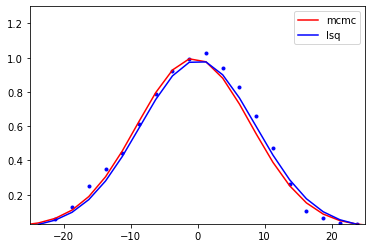

[ 9.96783821e-01  1.01627236e-03  8.28022171e+00 -5.16517717e-01
  8.49333308e+00  1.17254317e-02]
[-78.75 -76.25 -73.75 -71.25 -68.75 -66.25 -63.75 -61.25 -58.75 -56.25
 -53.75 -51.25 -48.75 -46.25 -43.75 -41.25 -38.75 -36.25 -33.75 -31.25
 -28.75 -26.25 -23.75 -21.25 -18.75 -16.25 -13.75 -11.25  -8.75  -6.25
  -3.75  -1.25   1.25   3.75   6.25   8.75  11.25  13.75  16.25  18.75
  21.25  23.75  26.25  28.75  31.25  33.75  36.25  38.75  41.25  43.75
  46.25  48.75  51.25  53.75  56.25  58.75  61.25  63.75  66.25  68.75
  71.25  73.75  76.25  78.75]


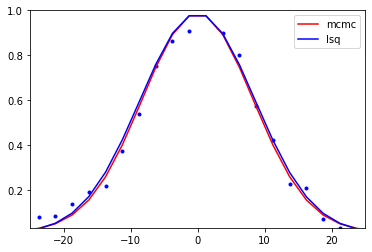

In [82]:
# overplot models and data to check::
xx=ptest.x_centers_grid[32,:,chind].flatten()
yy=ptest.y_centers_grid[32,:,chind].flatten()
print(samples[np.argmax(sampler.flatlnprobability),:])
fits_mcmc = model(samples[np.argmax(sampler.flatlnprobability),:],xx,yy)
fits_lin = model(G_popt[chind,find,:],xx,yy)

print(ptest.x_centers_grid[32,:,chind])
plt.plot(ptest.y_centers_grid[32,:,chind],ptest.V_LC_operation[32,:,0,chind],'b.')
plt.plot(yy,fits_mcmc,color='red',label='mcmc')
plt.plot(yy,fits_lin,color='blue',label='lsq')
plt.xlim(-25,25)
plt.ylim(3E-2,1.3)
plt.legend()
plt.show()


xx=ptest.x_centers_grid[:,32,chind].flatten()
yy=ptest.y_centers_grid[:,32,chind].flatten()
print(samples[np.argmax(sampler.flatlnprobability),:])
fits_mcmc = model(samples[np.argmax(sampler.flatlnprobability),:],xx,yy)
fits_lin = model(G_popt[chind,find,:],xx,yy)

print(ptest.x_centers_grid[:,32,chind])
plt.plot(ptest.x_centers_grid[:,32,chind],ptest.V_LC_operation[:,32,0,chind],'b.')
plt.plot(xx,fits_mcmc,color='red',label='mcmc')
plt.plot(xx,fits_lin,color='blue',label='lsq')
plt.xlim(-25,25)
plt.ylim(3E-2,1)
plt.legend()
plt.show()
#ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
#               np.abs(ptest.V_LC_operation[:,:,0,chind])